# Mean absolute value boosting

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import rc
import matplotlib
import numpy as np
from scipy.optimize import minimize_scalar
from sklearn.metrics import mean_squared_error, mean_absolute_error
#rc('text', usetex=True)
matplotlib.rcParams['mathtext.fontset'] = 'cm'
matplotlib.rcParams['mathtext.rm'] = 'serif'
matplotlib.rc('xtick', labelsize=13) 
matplotlib.rc('ytick', labelsize=13) 

bookcolors = {'crimson': '#a50026', 'red': '#d73027', 'redorange': '#f46d43',
              'orange': '#fdae61', 'yellow': '#fee090', 'sky': '#e0f3f8', 
              'babyblue': '#abd9e9', 'lightblue': '#74add1', 'blue': '#4575b4',
              'purple': '#313695'}

In [2]:
def data():
    df = pd.DataFrame(data={"sqfeet":[700,950,800,900,750]})
    df["rent"] = pd.Series([1125,1350,1135,1300,1150])
    df = df.sort_values('sqfeet')
    return df

df = data()
df

,sqfeet,rent
0,700,1125
4,750,1150
2,800,1135
3,900,1300
1,950,1350


In [3]:
def stub_predict(x_train, y_train, split):
    left = y_train[x_train<split]
    right = y_train[x_train>split]
    lmean = np.mean(left)
    rmean = np.mean(right)    
#     lw,rw = w
    lw,rw = 1,1
    return np.array([lw*lmean if x<split else rw*rmean for x in x_train])

eta = 1.0
splits = [None,850, 850, 725] # manually pick them
w = [None, (20,100), (5,30), (5,20)]
stages = 4

def boost(df, xcol, ycol, splits, eta, stages):
    """
    Update df to have direction_i, delta_i, F_i.
    Return MSE, MAE
    """
    f0 = df[ycol].median()
    df['F0'] = f0

    for s in range(1,stages):
        # print("Weight", w[s])
        df[f'dir{s}'] = np.sign(df[ycol] - df[f'F{s-1}'])
        df[f'delta{s}'] = stub_predict(df[xcol], df[f'dir{s}'], splits[s])
        weights = np.array([w[s][0] if x<splits[s] else w[s][1] for x in df[xcol]])
        df[f'wdelta{s}'] = df[f'delta{s}'] * weights
        df[f'F{s}'] = df[f'F{s-1}'] + eta * df[f'wdelta{s}']

    mse = [mean_squared_error(df[ycol], df['F'+str(s)]) for s in range(stages)]
    mae = [mean_absolute_error(df[ycol], df['F'+str(s)]) for s in range(stages)]
    return mse, mae

mse,mae = boost(df, 'sqfeet', 'rent', splits, eta, stages)
print(mse)
print(mae)
df['deltas'] = df[['delta1','delta2','delta3']].sum(axis=1) # sum deltas

df

[12670.0, 2563.333333333333, 1125.0, 660.0]
[78.0, 35.33333333333335, 23.0, 16.0]


,sqfeet,rent,F0,dir1,delta1,wdelta1,F1,dir2,delta2,wdelta2,F2,dir3,delta3,wdelta3,F3,deltas
0,700,1125,1150.0,-1.0,-0.666667,-13.333333,1136.666667,-1.0,-0.333333,-1.666667,1135.0,-1.0,-1.00,-5.0,1130.0,-2.00
4,750,1150,1150.0,0.0,-0.666667,-13.333333,1136.666667,1.0,-0.333333,-1.666667,1135.0,1.0,0.75,15.0,1150.0,-0.25
2,800,1135,1150.0,-1.0,-0.666667,-13.333333,1136.666667,-1.0,-0.333333,-1.666667,1135.0,0.0,0.75,15.0,1150.0,-0.25
3,900,1300,1150.0,1.0,1.000000,100.000000,1250.000000,1.0,1.000000,30.000000,1280.0,1.0,0.75,15.0,1295.0,2.75
1,950,1350,1150.0,1.0,1.000000,100.000000,1250.000000,1.0,1.000000,30.000000,1280.0,1.0,0.75,15.0,1295.0,2.75


In [4]:
# manually print table in python
# for small phone, make 2 tables
for i in range(len(df)):
    print( " & ".join([f"{int(v)}" for v in df.iloc[i,0:4]]), r"\\")

print
for i in range(len(df)):
    print( " & ".join([f"{int(v)}" for v in df.iloc[i,4:]]), r"\\")

700 & 1125 & 1150 & -1 \\
750 & 1150 & 1150 & 0 \\
800 & 1135 & 1150 & -1 \\
900 & 1300 & 1150 & 1 \\
950 & 1350 & 1150 & 1 \\
0 & -13 & 1136 & -1 & 0 & -1 & 1135 & -1 & -1 & -5 & 1130 & -2 \\
0 & -13 & 1136 & 1 & 0 & -1 & 1135 & 1 & 0 & 15 & 1150 & 0 \\
0 & -13 & 1136 & -1 & 0 & -1 & 1135 & 0 & 0 & 15 & 1150 & 0 \\
1 & 100 & 1250 & 1 & 1 & 30 & 1280 & 1 & 0 & 15 & 1295 & 2 \\
1 & 100 & 1250 & 1 & 1 & 30 & 1280 & 1 & 0 & 15 & 1295 & 2 \\


## Plot F0 vs rent

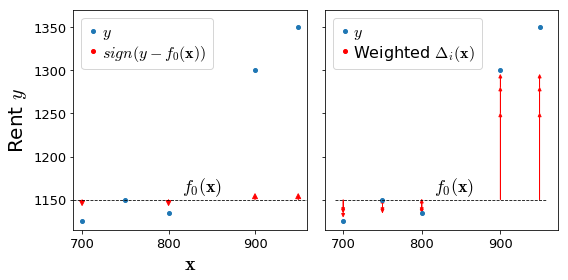

In [5]:
f0 = df.rent.median()
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 4), sharey=True)


ax = axes[0]
line1, = ax.plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4, label="$y$")
# fake a line to get smaller red dot
line2, = ax.plot(0,0,'o', c='r', markersize=4, label=r"$sign(y-f_0({\bf x}))$")
ax.plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c='k')
ax.set_xlim(df.sqfeet.min()-10,df.sqfeet.max()+10)
ax.set_ylim(df.rent.min()-10, df.rent.max()+20)
ax.text(815, f0+10, r"$f_0({\bf x})$", fontsize=18)

ax.set_ylabel(r"Rent $y$", fontsize=20)
ax.set_xlabel(r"${\bf x}$", fontsize=20)

# draw arrows
for x,y,yhat in zip(df.sqfeet,df.rent,df.F0):
    if y-yhat!=0:
        ax.arrow(x, yhat, 0, np.sign(y-yhat), # NO WEIGHT
                  fc='r', ec='r',
                  linewidth=0.8,
                  head_width=6, head_length=6
                 )
ax.legend(handles=[line1,line2], fontsize=16,
          loc='upper left', 
          labelspacing=.1,
          handletextpad=.2,
          handlelength=.7,
          frameon=True)

def draw_stage_residual(ax, df, stage):
    for x,d0,delta in zip(df.sqfeet,df[f'F{stage-1}'],df[f'F{stage}']):
        if delta-d0!=0:
#             print(x, d0, delta)
            ax.arrow(x, d0, 0, delta-d0,
                      fc='r', ec='r',
                      linewidth=0.8,
                      head_width=4, head_length=4,  
                      length_includes_head=True
                     )

ax = axes[1]
# plot from F0 to F1 to F2 to F3
line1, = ax.plot(df.sqfeet,df.rent,'o', linewidth=.8, markersize=4, label="$y$")
draw_stage_residual(ax, df, stage=1)
draw_stage_residual(ax, df, stage=2)
arrow = draw_stage_residual(ax, df, stage=3)
# fake a line to get smaller red dot
line2, = ax.plot(700,1000,'o', c='r', markersize=4, label=r"$w_1sign(y-f_0({\bf x}))$")
ax.plot([df.sqfeet.min()-10,df.sqfeet.max()+10], [f0,f0],
         linewidth=.8, linestyle='--', c='k')
ax.text(815, f0+10, r"$f_0({\bf x})$", fontsize=18)
ax.legend(handles=[line1,line2], fontsize=16,
          loc='upper left', 
          labelspacing=.1,
          handletextpad=.2,
          handlelength=.7,
          frameon=True,
          labels=["$y$","Weighted $\Delta_i({\\bf x})$"])

plt.tight_layout()
plt.savefig('/tmp/s.svg')
plt.show()

## Plot delta predictions versus residuals

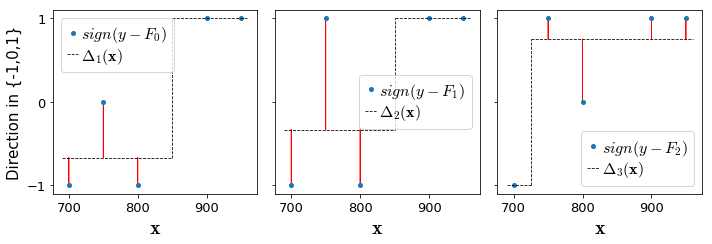

In [6]:
def draw_stub(ax, x_train, y_train, y_pred, split, stage, locs):
    line1, = ax.plot(x_train, y_train, 'o',
                     markersize=4,
                     label=f"$sign(y-F_{stage-1})$")
    label = r"$\Delta_"+str(stage)+r"({\bf x})$"
    left = y_pred[x_train<split]
    right = y_pred[x_train>split]
    lmean = np.mean(left)
    rmean = np.mean(right)
    line2, = ax.plot([x_train.min()-10,split], [lmean,lmean],
             linewidth=.8, linestyle='--', c='k', label=label)
    ax.plot([split,x_train.max()+10], [rmean,rmean],
             linewidth=.8, linestyle='--', c='k')
    ax.plot([split,split], [lmean,rmean],
             linewidth=.8, linestyle='--', c='k')
    ax.legend(handles=[line1,line2], fontsize=16,
              loc=locs[stage-1], 
              labelspacing=.1,
              handletextpad=.2,
              handlelength=.7,
              frameon=True)

def draw_residual(ax, df, stage):
    for x,d0,delta in zip(df.sqfeet,df[f'dir{stage}'],df[f'delta{stage}']):
        if delta-d0!=0:
#             print(x, d0, delta)
            ax.arrow(x, d0, 0, delta-d0,
                      fc='r', ec='r',
                      linewidth=0.8,
                     )

fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(10, 3.5), sharey=True, sharex=True)

ax = axes[0]
axes[0].set_ylabel(r"Direction in {-1,0,1}", fontsize=15)
axes[0].set_yticks([-1,0,1])
for a in range(3):
    axes[a].set_xlabel(r"${\bf x}$", fontsize=20)

locs = ['upper left','center right','lower right']
draw_stub(axes[0], df.sqfeet, df.dir1, df.delta1, splits[1], stage=1, locs=locs)
draw_residual(axes[0], df, stage=1)

draw_stub(axes[1], df.sqfeet, df.dir2, df.delta2, splits[2], stage=2, locs=locs)
draw_residual(axes[1], df, stage=2)

draw_stub(axes[2], df.sqfeet, df.dir3, df.delta3, splits[3], stage=3, locs=locs)
draw_residual(axes[2], df, stage=3)

plt.tight_layout()
        
plt.savefig('/tmp/t.svg')
plt.show()

## Show MAE for various learning rates

In [7]:
stages = 4

df_mae = pd.DataFrame(data={"stage":range(stages)})

for eta in np.arange(.5, 4, .1):
    df = data() # fresh data
    mse,mae = boost(df, 'sqfeet', 'rent', splits, eta, stages)
    df_mae[f'mae_{eta:.2f}'] = mae

df_mae

,stage,mae_0.50,mae_0.60,mae_0.70,mae_0.80,mae_0.90,mae_1.00,mae_1.10,mae_1.20,mae_1.30,...,mae_3.00,mae_3.10,mae_3.20,mae_3.30,mae_3.40,mae_3.50,mae_3.60,mae_3.70,mae_3.80,mae_3.90
0,0,78.000000,78.0,78.000000,78.000000,78.0,78.000000,78.000000,78.0,78.000000,...,78.0,78.000000,78.000000,78.0,78.000000,78.000000,78.0,78.000000,78.000000,78.0
1,1,56.666667,52.4,48.133333,43.866667,39.6,35.333333,31.066667,27.2,23.466667,...,66.0,70.800000,75.600000,80.4,85.200000,90.000000,94.8,99.600000,104.400000,109.2
2,2,50.500000,45.0,39.500000,34.000000,28.5,23.000000,18.100000,15.2,15.033333,...,21.0,24.300000,27.600000,30.9,34.200000,37.500000,40.8,44.100000,47.400000,50.7
3,3,48.000000,42.0,36.000000,30.000000,24.0,16.000000,15.800000,14.0,13.666667,...,21.0,27.066667,30.133333,33.2,36.266667,39.333333,42.4,45.466667,48.533333,51.6


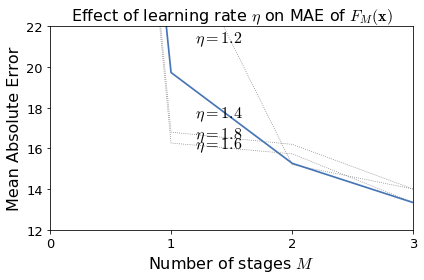

In [8]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 4), sharex=True)

maxy = 22
max_eta = 2
min_eta = 1.2
mins = []
for eta in np.arange(min_eta, max_eta, .2):
    mins.append( np.min(df_mae[f'mae_{eta:.2f}']) )

min_eta_index = np.argmin(mins)
# print("Best index is ", min_eta_index, list(np.arange(min_eta, max_eta, .2))[min_eta_index])

i = 0
for eta in np.arange(min_eta, max_eta, .2):
    color = 'grey'
    lw = .8
    ls = ':'
    if i==min_eta_index:
        color = bookcolors['blue']
        lw = 1.7
        ls = '-'
    ax.plot(df_mae.stage,df_mae[f'mae_{eta:.2f}'],
            linewidth=lw,
            linestyle=ls,
            c=color)
    xloc = 1.2
    yloc = (df_mae[f'mae_{eta:.2f}'].values[1] + df_mae[f'mae_{eta:.2f}'].values[2])/2
    if yloc>maxy:
        yloc = maxy-100
        xloc +=  .5
    ax.text(xloc, yloc, f"$\\eta={eta:.1f}$",
            fontsize=16)
    i += 1

plt.axis([0,stages-1,12,maxy])

ax.set_ylabel(r"Mean Absolute Error", fontsize=16)
ax.set_xlabel(r"Number of stages $M$", fontsize=16)
ax.set_title(r'Effect of learning rate $\eta$ on MAE of $F_M({\bf x})$', fontsize=16)
ax.set_xticks(range(0,stages))

plt.tight_layout()
plt.show()

## Show composite model

In [9]:
# Hideous manual computation of composite graph but...

df = data()
eta = 1
mse,mae = boost(df, 'sqfeet', 'rent', splits, eta, stages)
df['deltas'] = eta * df[['wdelta1','wdelta2','wdelta3']].sum(axis=1) # sum deltas
df[['sqfeet','rent','F0','wdelta1','wdelta2','wdelta3','deltas','F3']]

,sqfeet,rent,F0,wdelta1,wdelta2,wdelta3,deltas,F3
0,700,1125,1150.0,-13.333333,-1.666667,-5.0,-2.000000e+01,1130.0
4,750,1150,1150.0,-13.333333,-1.666667,15.0,1.776357e-15,1150.0
2,800,1135,1150.0,-13.333333,-1.666667,15.0,1.776357e-15,1150.0
3,900,1300,1150.0,100.000000,30.000000,15.0,1.450000e+02,1295.0
1,950,1350,1150.0,100.000000,30.000000,15.0,1.450000e+02,1295.0


In [10]:
def stub_predict_w(x_train, y_train, split, w):
    left = y_train[x_train<split]
    right = y_train[x_train>split]
    lmean = np.mean(left)
    rmean = np.mean(right)    
    lw,rw = w
    return np.array([lw*lmean if x<split else rw*rmean for x in x_train])

def predict(df, splits, w, stages):
    f0 = df.rent.median()
    F0 = f0
    Fprev = F0
    eta = 1
    
    for s in range(1,stages):
#         print("Weight", w[s])
        dir = np.sign(df.rent - Fprev)
        delta = stub_predict_w(df.sqfeet, dir, splits[s], w[s])
#         print(delta)
        Fnext = Fprev + eta * delta
#         print(f"F{s}={Fnext}")
        Fprev = Fnext

predict(df, splits, w, 4)

In [11]:
df.sqfeet.values

array([700, 750, 800, 900, 950])

In [12]:
# Iterate through F3, finding split points in predicted rent
# and create coordinate list to draw lines
split_x_locs = []
x_prev = np.min(df.sqfeet)
y_prev = np.min(df.F3)
X = df.sqfeet.values
coords = []
for i,y_hat in enumerate(df.F3.values):
    if y_hat!=y_prev:
        mid = (X[i]+X[i-1])/2
        coords.append((mid,y_prev))
        coords.append((mid,y_hat))
        coords.append((X[i],y_hat))
    else:
        coords.append((X[i],y_hat))
    y_prev = y_hat

print(coords)

[(700, 1130.0), (725.0, 1130.0), (725.0, 1150.0), (750, 1150.0), (800, 1150.0), (850.0, 1150.0), (850.0, 1295.0), (900, 1295.0), (950, 1295.0)]


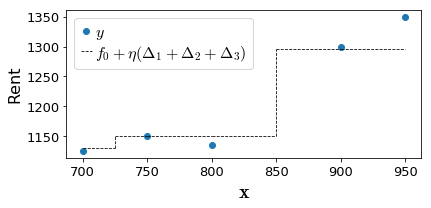

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6.1, 3))

line1, = ax.plot(df.sqfeet,df.rent, 'o', label=r'$y$')

prev = None
for x,y in coords:
    if prev is not None:
        line2, = ax.plot([prev[0],x], [prev[1],y], linewidth=.8,
                         linestyle='--', c='k',
                         label=r"$f_0 + \eta (\Delta_1+\Delta_2+\Delta_3)$")
    prev = (x,y)

ax.set_ylabel(r"Rent", fontsize=16)
ax.set_xlabel(r"${\bf x}$", fontsize=20)

ax.set_yticks(np.arange(1150,1351,50))

ax.legend(handles=[line1,line2], fontsize=16,
          loc='upper left', 
          labelspacing=.1,
          handletextpad=.2,
          handlelength=.7,
          frameon=True)

plt.tight_layout()
plt.show()